
# Embedding Analysis – Rotational Symmetry Toy Model

This notebook loads the saved polar-grid embeddings from `embeddings_grid.npz` (and optionally the model from `toy_symmetry_model.pt`) and produces **basic diagnostic plots** of the embedding space.  
Guidelines followed here:
- Matplotlib only (no seaborn)
- One chart per cell (no subplots)
- No explicit color choices; defaults are used

> The goal is to quickly visualize whether the bottleneck embedding collapses angular information and/or tracks radius for the symmetric target \(f(\mathbf{x}) = \sin(\|\mathbf{x}\|)\).


In [1]:
# --------------------
# Imports & Data Load
# --------------------
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Optional: model reload if needed for extra experiments
import torch
import torch.nn as nn

FILE_DIR = "runs/symmetry_run_9000"
DATA_PATH = os.path.join(FILE_DIR, "embeddings_grid.npz")
MODEL_PATH = os.path.join(FILE_DIR, "toy_symmetry_model.pt")

assert os.path.exists(DATA_PATH), f"Missing {DATA_PATH}. Run training notebook first."
data = np.load(DATA_PATH)
XY = data["xy"]            # [N,2]
Z = data["z"]              # [N,embed_dim]
pred = data["pred"]        # [N]
radii = data["radii"]      # [N]
thetas = data["thetas"]    # [N]

N, embed_dim = Z.shape
print(f"N={N}, embed_dim={embed_dim}")
print("XY range:", XY.min(axis=0), "to", XY.max(axis=0))
print("radii: ", radii.min(), "to", radii.max())

# True function values (for reference)
y_true = np.sin(radii)

# Figure output directory (optional)
FIGDIR = "figs"
os.makedirs(FIGDIR, exist_ok=True)
print("Saving figures to:", os.path.abspath(FIGDIR))

# (Optional) Load model payload
if os.path.exists(MODEL_PATH):
    payload = torch.load(MODEL_PATH, map_location="cpu")
    print("Model metadata:", payload.get("config", {}))
else:
    print("Model file not found; proceeding with embedding-only analysis.")

N=10240, embed_dim=2
XY range: [-4.2426405 -4.2426405] to [4.2426405 4.2426405]
radii:  0.0 to 4.2426405
Saving figures to: /Users/noah-everett/Documents/Research/Embedding-Analysis/figs
Model file not found; proceeding with embedding-only analysis.


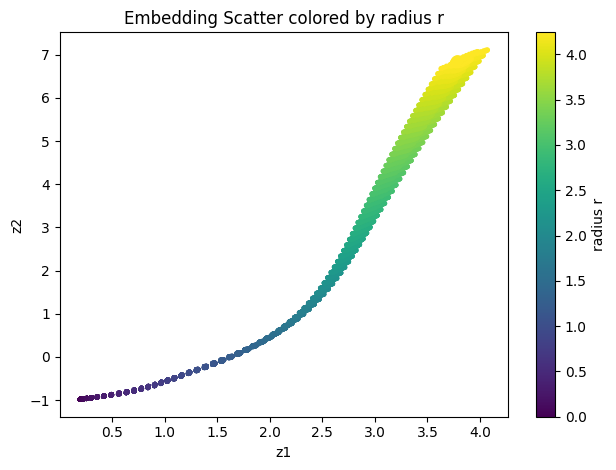

In [2]:
# --------------------
# Plot 1: Embedding scatter (Z[:,0] vs Z[:,1]) colored by radius
# --------------------
plt.figure()
sc = plt.scatter(Z[:, 0], Z[:, 1], s=6, c=radii)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Embedding Scatter colored by radius r")
cb = plt.colorbar(sc)
cb.set_label("radius r")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "embedding_scatter_by_radius.png"), dpi=160)
plt.show()

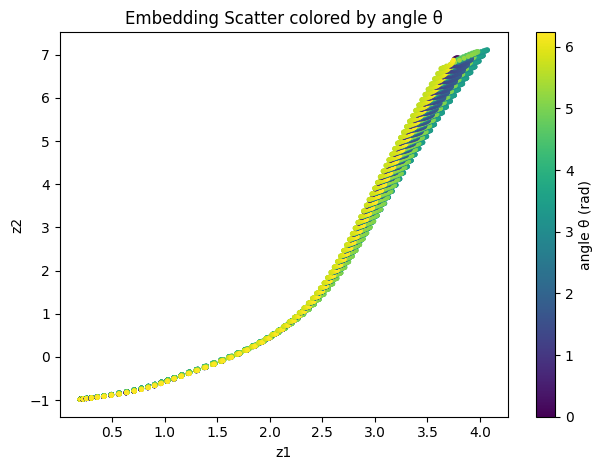

In [3]:
# --------------------
# Plot 2: Embedding scatter colored by angle theta
# --------------------
plt.figure()
sc = plt.scatter(Z[:, 0], Z[:, 1], s=6, c=thetas)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Embedding Scatter colored by angle θ")
cb = plt.colorbar(sc)
cb.set_label("angle θ (rad)")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "embedding_scatter_by_theta.png"), dpi=160)
plt.show()

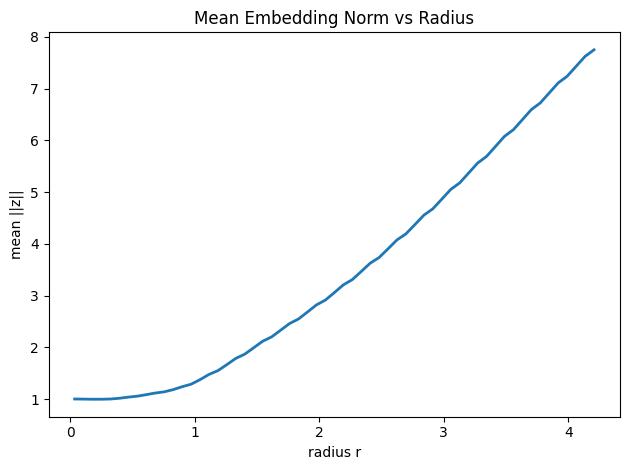

In [4]:
# --------------------
# Plot 3: Mean embedding norm vs radius (angularly averaged)
# --------------------
z_norm = np.linalg.norm(Z, axis=1)
bins = np.linspace(radii.min(), radii.max(), 60)
centers = 0.5 * (bins[:-1] + bins[1:])
mean_norm = []
for lo, hi in zip(bins[:-1], bins[1:]):
    m = (radii >= lo) & (radii < hi)
    if np.any(m):
        mean_norm.append(z_norm[m].mean())
    else:
        mean_norm.append(np.nan)
mean_norm = np.array(mean_norm)

plt.figure()
plt.plot(centers, mean_norm, linewidth=2.0)
plt.xlabel("radius r")
plt.ylabel("mean ||z||")
plt.title("Mean Embedding Norm vs Radius")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "mean_embedding_norm_vs_radius.png"), dpi=160)
plt.show()

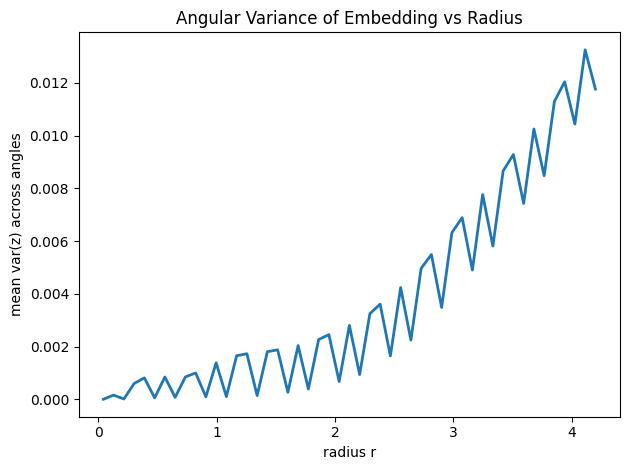

In [5]:
# --------------------
# Plot 4: Angular variance of embedding (average over bins)
# --------------------
bins = np.linspace(radii.min(), radii.max(), 50)
centers = 0.5 * (bins[:-1] + bins[1:])
ang_var = []
for lo, hi in zip(bins[:-1], bins[1:]):
    m = (radii >= lo) & (radii < hi)
    if np.sum(m) > 1:
        var = Z[m].var(axis=0).mean()
        ang_var.append(var)
    else:
        ang_var.append(np.nan)
ang_var = np.array(ang_var)

plt.figure()
plt.plot(centers, ang_var, linewidth=2.0)
plt.xlabel("radius r")
plt.ylabel("mean var(z) across angles")
plt.title("Angular Variance of Embedding vs Radius")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "angular_variance_vs_radius.png"), dpi=160)
plt.show()

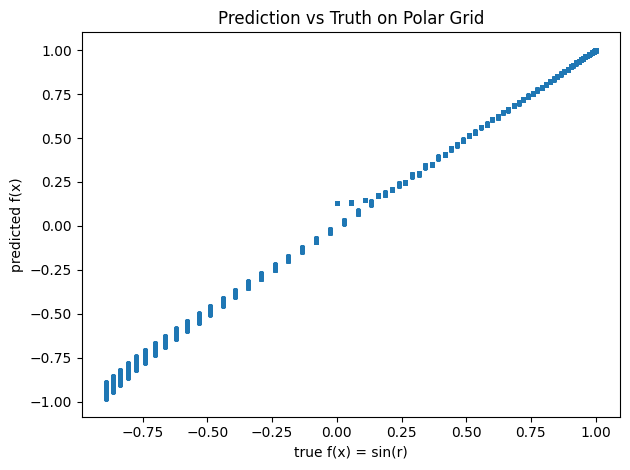

In [6]:
# --------------------
# Plot 5: Predicted f vs True f (scatter)
# --------------------
plt.figure()
plt.scatter(y_true, pred, s=6)
plt.xlabel("true f(x) = sin(r)")
plt.ylabel("predicted f(x)")
plt.title("Prediction vs Truth on Polar Grid")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "pred_vs_true.png"), dpi=160)
plt.show()

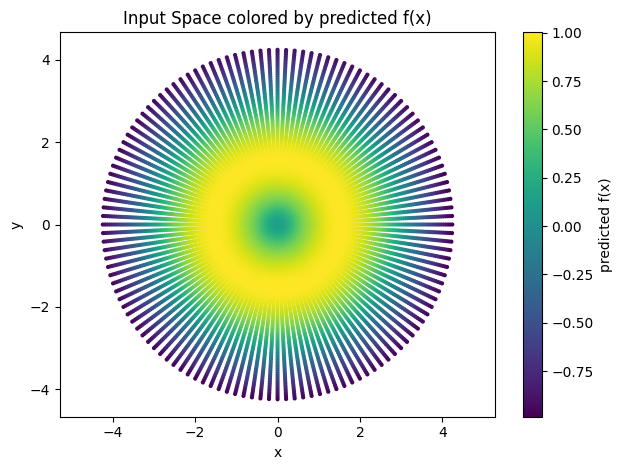

In [7]:
# --------------------
# Plot 6: Input XY colored by prediction
# --------------------
plt.figure()
sc = plt.scatter(XY[:, 0], XY[:, 1], s=4, c=pred)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Space colored by predicted f(x)")
cb = plt.colorbar(sc)
cb.set_label("predicted f(x)")
plt.axis("equal")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "xy_colored_by_pred.png"), dpi=160)
plt.show()

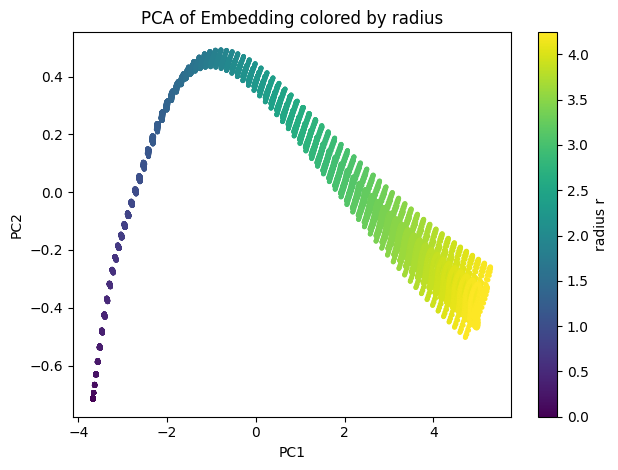

In [8]:
# --------------------
# Plot 7: PCA of embedding (first 2 PCs) colored by radius
# --------------------
Zc = Z - Z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
PC = Zc @ Vt[:2].T  # first 2 principal components

plt.figure()
sc = plt.scatter(PC[:, 0], PC[:, 1], s=6, c=radii)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Embedding colored by radius")
cb = plt.colorbar(sc)
cb.set_label("radius r")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "pca_embedding_by_radius.png"), dpi=160)
plt.show()

In [9]:
# --------------------
# Numeric summaries
# --------------------
from collections import OrderedDict
summ = OrderedDict()
summ["N"] = int(Z.shape[0])
summ["embed_dim"] = int(Z.shape[1])
summ["mean_z_norm"] = float(np.linalg.norm(Z, axis=1).mean())
summ["std_z_norm"] = float(np.linalg.norm(Z, axis=1).std())
summ["mean_abs_error"] = float(np.mean(np.abs(pred - np.sin(radii))))
summ["rmse"] = float(np.sqrt(np.mean((pred - np.sin(radii))**2)))

for k, v in summ.items():
    print(f"{k}: {v}")

N: 10240
embed_dim: 2
mean_z_norm: 3.5198631286621094
std_z_norm: 2.192715644836426
mean_abs_error: 0.00962897390127182
rmse: 0.021052559837698936
